### Can we identify countries that are similar in their countermeasures implementation?

Hypothesis

-------------------

Countries that have similar countermeasures implementation should converge towards similar dynamics

Data Sources

-------------------

BGS data source 

SIR model coefficients country wide

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(42)

%matplotlib inline

To begin, Cluster countries based on stringency index vectors




In [2]:
#Read measures file and construct stringency vectors countrywise
df_measures = pd.read_csv('https://ocgptweb.azurewebsites.net/CSVDownload')
df_measures.columns

Index(['CountryName', 'CountryCode', 'Date', 'S1_School closing',
       'S1_IsGeneral', 'S1_Notes', 'S2_Workplace closing', 'S2_IsGeneral',
       'S2_Notes', 'S3_Cancel public events', 'S3_IsGeneral', 'S3_Notes',
       'S4_Close public transport', 'S4_IsGeneral', 'S4_Notes',
       'S5_Public information campaigns', 'S5_IsGeneral', 'S5_Notes',
       'S6_Restrictions on internal movement', 'S6_IsGeneral', 'S6_Notes',
       'S7_International travel controls', 'S7_Notes', 'S8_Fiscal measures',
       'S8_Notes', 'S9_Monetary measures', 'S9_Notes',
       'S10_Emergency investment in health care', 'S10_Notes',
       'S11_Investment in Vaccines', 'S11_Notes', 'ConfirmedCases',
       'ConfirmedDeaths', 'StringencyIndex', 'Unnamed: 34'],
      dtype='object')

In [3]:
stringent_indices = []
stringent_nations = []

for _countryname in df_measures['CountryName'].unique():
    _string_vec = df_measures[df_measures['CountryName']==_countryname][['StringencyIndex','S1_School closing',
                                                                       'S3_Cancel public events',
                                                                       'S6_Restrictions on internal movement',
                                                                       'S7_International travel controls']].dropna().values
    if len(_string_vec)>10:# ensure we've got atleast a dozen entries
        stringent_indices.append(_string_vec)
        stringent_nations.append(_countryname)
        
stringent_nations = np.array(stringent_nations)
    


Clearly, different countries have different length responses. We need to have an elastic measure to match the differing time series lengths. Use the tslearn package with Global Alignment Kernel. Use Silhoutte measures to extract the best possible number of clusters

In [4]:
from tslearn.utils import to_time_series_dataset
X_stringent = to_time_series_dataset(stringent_indices)

from tslearn.clustering import TimeSeriesKMeans, GlobalAlignmentKernelKMeans, silhouette_score
for n_cluster in [2,3,4,5,10,15,25,50]:
    pred_labels = GlobalAlignmentKernelKMeans(n_clusters=n_cluster,random_state=0).fit_predict(X_stringent)
    print(n_cluster,silhouette_score(X_stringent,pred_labels))

2 0.022916717297211835
3 -0.06034126415040377
4 -0.09284605670144293
5 -0.13633146433525434
10 -0.21284028163487592
15 -0.3505767490381463
25 -0.4108248954165354
50 -0.32406374213082306


It appears that there are just 2 clusters..Identify the countries in the 2 clusters

In [5]:
pred_labels = GlobalAlignmentKernelKMeans(n_clusters=2,random_state=0).fit_predict(X_stringent)
cluster1_members, cluster2_members = stringent_nations[pred_labels==0], stringent_nations[pred_labels==1]
print(len(cluster1_members),len(cluster2_members))

25 37


Read now the SIR model coefficients for all countries

In [6]:
df_sir = pd.read_csv('all_countries_sir_model.csv')

Visualize the spread and recovery probabilities according to cluster membership

Insert a color column in df_sir with color values given by class membership

In [7]:
import difflib
df_sir['color'] = ['c' for n in range(len(df_sir))]
for _country in cluster1_members:
    try:
        
        df_sir.at[df_sir[df_sir['country']==_country].index[0],'color'] = 'r'
    except:
        # Except for missing cases, see if closest match makes sense at all
        print(_country,difflib.get_close_matches(_country,df_sir['country'].values))
        pass
    
for _country in cluster2_members:
    try:
        
        df_sir.at[df_sir[df_sir['country']==_country].index[0],'color'] = 'b'
    except:
        # Except for missing cases, see if closest match makes sense at all
        print(_country,difflib.get_close_matches(_country,df_sir['country'].values))
        pass
        
        

South Korea ['South Africa', 'South Sudan']
Macao ['Monaco', 'Malta']
United States ['United Arab Emirates']
Democratic Republic of Congo []
Bermuda ['Burma']
Canada ['Uganda', 'Rwanda', 'Panama']
Czech Republic ['Central African Republic', 'Dominican Republic']
Hong Kong []
Myanmar ['Panama', 'Guyana']
Slovak Republic ['Dominican Republic', 'Slovakia']


(0.07, 0.11)

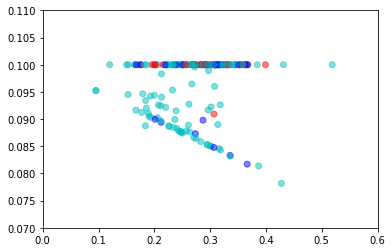

In [8]:
plt.scatter((df_sir['spread'].values),(df_sir['recovery'].values),c=df_sir['color'].values,alpha=0.5)
plt.xlim([0,0.6])
plt.ylim([0.07,0.11])

b'Skipping line 22: expected 2 fields, saw 3\nSkipping line 29: expected 2 fields, saw 3\nSkipping line 81: expected 2 fields, saw 3\nSkipping line 90: expected 2 fields, saw 3\nSkipping line 91: expected 2 fields, saw 3\nSkipping line 106: expected 2 fields, saw 3\nSkipping line 109: expected 2 fields, saw 3\nSkipping line 138: expected 2 fields, saw 3\nSkipping line 151: expected 2 fields, saw 3\nSkipping line 172: expected 2 fields, saw 3\nSkipping line 179: expected 2 fields, saw 3\n'
/home/sds/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/home/sds/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyErr

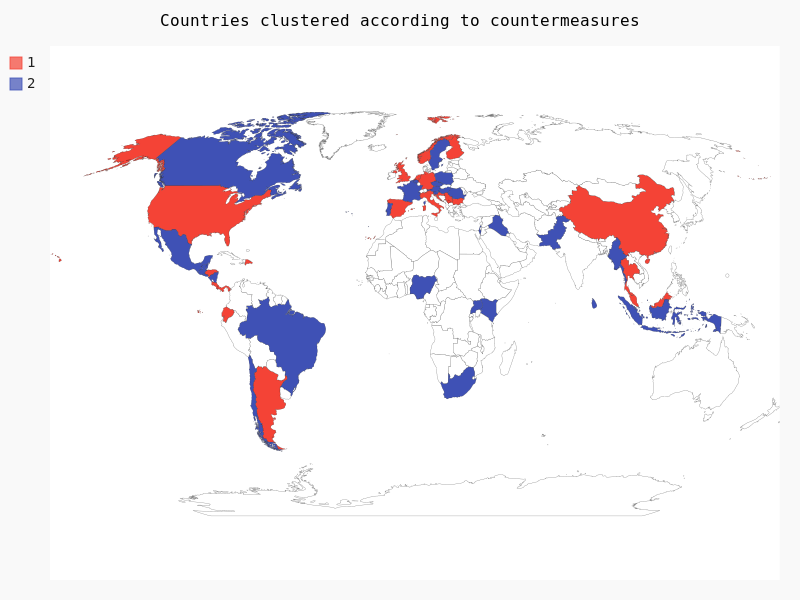

In [42]:
from IPython.core.display import SVG as core_svg
from IPython.display import SVG, display, Image
import pygal
worldmap_chart = pygal.maps.world.World()
worldmap_chart.title = 'Countries clustered according to countermeasures'
df_country_code = pd.read_csv('../../../data/sun/geo/country_name_code.csv',error_bad_lines=False)
df_country_code.index = df_country_code['Country'].values
worldmap_chart.add('1', df_country_code.loc[list(cluster1_members)]['code'].values)
worldmap_chart.add('2', df_country_code.loc[list(cluster2_members)]['code'].values)


worldmap_chart.render_to_png('cluster_countries.png')

Image(filename='cluster_countries.png')